In [ ]:
# default_exp rl.envs.bandits

# Bandit RL Environments
> Bandit RL Environments.

- `BanditTwoArmedDeterministicFixed-v0`: Simplest case where one bandit always pays, and the other always doesn't. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [1, 0]
    - r_dist = [1, 1]
- `BanditTwoArmedHighLowFixed-v0`: Stochastic version with a large difference between which bandit pays out of two choices. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.8, 0.2]
    - r_dist = [1, 1]
- `BanditTwoArmedHighHighFixed-v0`: Stochastic version with a small difference between which bandit pays where both are good. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.8, 0.9]
    - r_dist = [1, 1]
- `BanditTwoArmedLowLowFixed-v0`: Stochastic version with a small difference between which bandit pays where both are bad. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.1, 0.2]
    - r_dist = [1, 1]
- `BanditTenArmedRandomFixed-v0`: 10 armed bandit with random probabilities assigned to payouts. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = numpy.random.uniform(size=10)
    - r_dist = numpy.full(bandits, 1)
    - Bandits have a uniform probability of rewarding and always reward 1
- `BanditTenArmedRandomRandom-v0`: 10 armed bandit with random probabilities assigned to both payouts and rewards. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = numpy.random.uniform(size=10)
    - r_dist = numpy.random.uniform(size=10)
    - Bandits have uniform probability of paying out and payout a reward of uniform probability
- `BanditTenArmedUniformDistributedReward-v0`: 10 armed bandit with that always pays out with a reward selected from a uniform distribution. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded  the bandit does payout.
    - p_dist = numpy.full(bandits, 1)
    - r_dist = numpy.random.uniform(size=10)
    - Bandits always pay out. Reward is selected from uniform distribution
- `BanditTenArmedGaussian-v0`: 10 armed bandit mentioned on page 30 of [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0) (Sutton and Barto). Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [1] (* 10)
    - r_dist = [numpy.random.normal(0, 1), 1] (* 10)
    - Every bandit always pays out
    - Each action has a reward mean (selected from a normal distribution with mean 0 and std 1), and the actual reward returns is selected with a std of 1 around the selected mean.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np

import gym
from gym import spaces
from gym.utils import seeding

In [ ]:
#exporti
class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass

## Solving Multi-armed Bandit Problems
We will focus on how to solve the multi-armed bandit problem using four strategies, including epsilon-greedy, softmax exploration, upper confidence bound, and Thompson sampling. We will see how they deal with the exploration-exploitation dilemma in their own unique ways. We will also work on a billion-dollar problem, online advertising, and demonstrate how to solve it using a multi-armed bandit algorithm. Finally, we will solve the contextual advertising problem using contextual bandits to make more informed decisions in ad optimization.

The multi-armed bandit problem is one of the simplest reinforcement learning problems. It is best described as a slot machine with multiple levers (arms), and each lever has a different payout and payout probability. Our goal is to discover the best lever with the maximum return so that we can keep choosing it afterward.

### Solving with Random Policy

In the example we just worked on, there are three slot machines. Each machine has a different payout (reward) and payout probability. In each episode, we randomly chose one arm of the machine to pull (one action to execute) and get a payout at a certain probability.

Arm 1 is the best arm with the largest average reward. Also, the average rewards start to saturate round 10,000 episodes.

This solution seems very naive as we only perform an exploration of all arms. We will come up with more intelligent strategies in the upcoming sections.

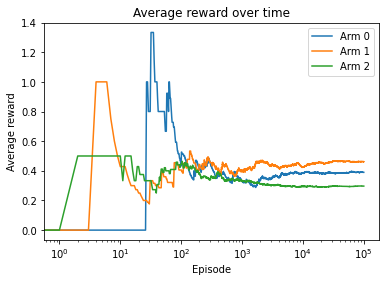

In [ ]:
import torch
import matplotlib.pyplot as plt

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]

def random_policy():
    action = torch.multinomial(torch.ones(n_action), 1).item()
    return action

for episode in range(n_episode):
    action = random_policy()
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

### Solving with Epsilon-greedy Policy

Instead of exploring solely with random policy, we can do better with a combination of exploration and exploitation. Here comes the well-known epsilon-greedy policy.

Epsilon-greedy for multi-armed bandits exploits the best action the majority of the time and also keeps exploring different actions from time to time. Given a parameter, ε, with a value from 0 to 1, the probabilities of performing exploration and exploitation are ε and 1 - ε, respectively.

Similar to other MDP problems, the epsilon-greedy policy selects the best arm with a probability of 1 - ε and performs random exploration with a probability of ε. Epsilon manages the trade-off between exploration and exploitation.

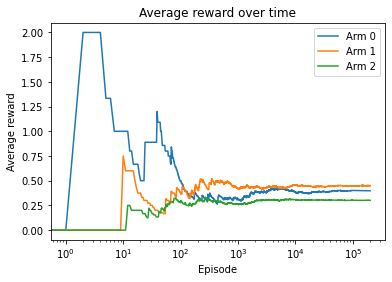

In [ ]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

epsilon = 0.2

epsilon_greedy_policy = gen_epsilon_greedy_policy(n_action, epsilon)


Q = torch.zeros(n_action)

for episode in range(n_episode):
    action = epsilon_greedy_policy(Q)
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Arm 1 is the best arm, with the largest average reward at the end. Also, its average reward starts to saturate after around 1,000 episodes.

You may wonder whether the epsilon-greedy policy actually outperforms the random policy. Besides the fact that the value for the optimal arm converges earlier with the epsilon-greedy policy, we can also prove that, on average, the reward we get during the course of training is higher with the epsilon-greedy policy than the random policy.

We can simply average the reward over all episodes:

In [ ]:
print(sum(action_total_reward) / n_episode)

0.81927


### Solving with Softmax-exploration Policy

As we’ve seen with epsilon-greedy, when performing exploration we randomly select one of the non-best arms with a probability of ε/|A|. Each non-best arm is treated equivalently regardless of its value in the Q function. Also, the best arm is chosen with a fixed probability regardless of its value. In softmax exploration, an arm is chosen based on a probability from the softmax distribution of the Q function values.

With the softmax exploration strategy, the dilemma of exploitation and exploration is solved with a softmax function based on the Q values. Instead of using a fixed pair of probabilities for the best arm and non-best arms, it adjusts the probabilities according to the softmax distribution with the τ parameter as a temperature factor. The higher the value of τ, the more focus will be shifted to exploration.

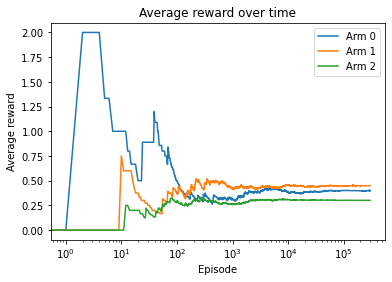

In [ ]:
def gen_softmax_exploration_policy(tau):
    def policy_function(Q):
        probs = torch.exp(Q / tau)
        probs = probs / torch.sum(probs)
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

tau = 0.1

softmax_exploration_policy = gen_softmax_exploration_policy(tau)

Q = torch.zeros(n_action)

for episode in range(n_episode):
    action = softmax_exploration_policy(Q)
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Arm 1 is the best arm, with the largest average reward at the end. Also, its average reward starts to saturate after around 800 episodes in this example.

### Solving with UCB

In the previous two recipes, we explored random actions in the multi-armed bandit problem with probabilities that are either assigned as fixed values in the epsilon-greedy policy or computed based on the Q-function values in the softmax exploration algorithm. In either algorithm, the probabilities of taking random actions are not adjusted over time. Ideally, we want less exploration as learning progresses. In this recipe, we will use a new algorithm called upper confidence bound to achieve this goal.

The upper confidence bound (UCB) algorithm stems from the idea of the confidence interval. In general, the confidence interval is a range of values where the true value lies. In the UCB algorithm, the confidence interval for an arm is a range where the mean reward obtained with this arm lies. The interval is in the form of [lower confidence bound, upper confidence bound] and we only use the upper bound, which is the UCB, to estimate the potential of the arm. The UCB is computed as follows:

$$UCB(a) = Q(a) + \sqrt{2log(t)/N(a)}$$

Here, t is the number of episodes, and N(a) is the number of times arm a is chosen among t episodes. As learning progresses, the confidence interval shrinks and becomes more and more accurate. The arm to pull is the one with the highest UCB.

In this recipe, we solved the multi-armed bandit with the UCB algorithm. It adjusts the exploitation-exploration dilemma according to the number of episodes. For an action with a few data points, its confidence interval is relatively wide, hence, choosing this action is of relatively high uncertainty. With more episodes of the action being selected, the confidence interval becomes narrow and shrinks to its actual value. In this case, it is of high certainty to choose (or not) this action. Finally, the UCB algorithm pulls the arm with the highest UCB in each episode and gains more and more confidence over time.

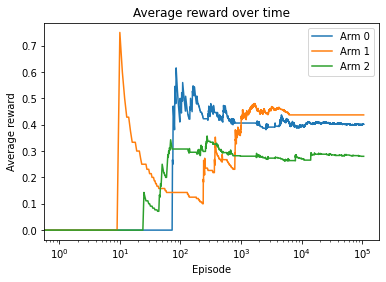

In [ ]:
def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb).item()

Q = torch.empty(n_action)

for episode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Arm 1 is the best arm, with the largest average reward in the end.

You may wonder whether UCB actually outperforms the epsilon-greedy policy. We can compute the average reward over the entire training process, and the policy with the highest average reward learns faster.

We can simply average the reward over all episodes:

In [ ]:
print(sum(action_total_reward) / n_episode)

0.42628


## Solving internet advertising problems with a multi-armed bandit

Imagine you are an advertiser working on ad optimization on a website:

There are three different colors of ad background – red, green, and blue. Which one will achieve the best click-through rate (CTR)?

There are three types of wordings of the ad – learn …, free …, and try …. Which one will achieve the best CTR?

For each visitor, we need to choose an ad in order to maximize the CTR over time. How can we solve this?

Perhaps you are thinking about A/B testing, where you randomly split the traffic into groups and assign each ad to a different group, and then choose the ad from the group with the highest CTR after a period of observation. However, this is basically a complete exploration, and we are usually unsure of how long the observation period should be and will end up losing a large portion of potential clicks. Besides, in A/B testing, the unknown CTR for an ad is assumed to not change over time. Otherwise, such A/B testing should be re-run periodically.

A multi-armed bandit can certainly do better than A/B testing. Each arm is an ad, and the reward for an arm is either 1 (click) or 0 (no click).

### Solving with UCB

Let’s try to solve it with the UCB algorithm.

In this recipe, we solved the ad optimization problem in a multi-armed bandit manner. It overcomes the challenges confronting the A/B testing approach. We used the UCB algorithm to solve the multi-armed (multi-ad) bandit problem; the reward for each arm is either 1 or 0. Instead of pure exploration and no interaction between action and reward, UCB (or other algorithms such as epsilon-greedy and softmax exploration) dynamically switches between exploitation and exploration where necessarly. For an ad with a few data points, the confidence interval is relatively wide, hence, choosing this action is of relatively high uncertainty. With more episodes of the ad being selected, the confidence interval becomes narrow and shrinks to its actual value.

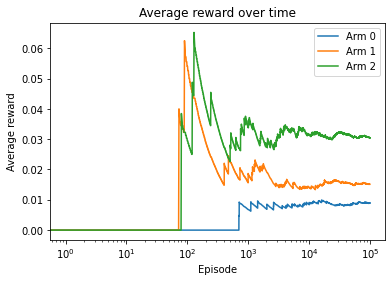

In [ ]:
bandit_payout = [0.01, 0.015, 0.03]
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]

def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb).item()

Q = torch.empty(n_action)

for episode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Ad 2 is the best ad with the highest predicted CTR (average reward) after the model converges.

Eventually, we found that ad 2 is the optimal one to choose, which is true. Also, the sooner we figure this out the better, because we will lose fewer potential clicks. In this example, ad 2 outperformed the others after around 1000 episodes.

### Solving with Thompson Sampling

In this recipe, we solved the ad bandits problem with the TS algorithm. The biggest difference between TS and the three other approaches is the adoption of Bayesian optimization. It first computes the prior distribution for each possible arm, and then randomly draws a value from each distribution. It then picks the arm with the highest value and uses the observed outcome to update the prior distribution. The TS policy is both stochastic and greedy. If an ad is more likely to receive clicks, its beta distribution shifts toward 1 and, hence, the value of a random sample tends to be closer to 1.

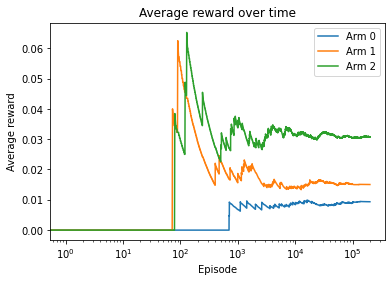

In [ ]:
def thompson_sampling(alpha, beta):
    prior_values = torch.distributions.beta.Beta(alpha, beta).sample()
    return torch.argmax(prior_values).item()

alpha = torch.ones(n_action)
beta = torch.ones(n_action)

for episode in range(n_episode):
    action = thompson_sampling(alpha, beta)
    reward = bandit_env.step(action)[1]
    action_count[action] += 1
    action_total_reward[action] += reward

    if reward > 0:
        alpha[action] += 1
    else:
        beta[action] += 1

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

As seen already, Ad 2 is the best ad, with the highest predicted CTR (average reward).

### Solving with Contextual Bandits

You may notice that in the ad optimization problem, we only care about the ad and ignore other information, such as user information and web page information, that might affect the ad being clicked on or not. In this recipe, we will talk about how we take more information into account beyond the ad itself and solve the problem with contextual bandits.

The multi-armed bandit problems we have worked with so far do not involve the concept of state, which is very different from MDPs. We only have several actions, and a reward will be generated that is associated with the action selected. Contextual bandits extend multi-armed bandits by introducing the concept of state. State provides a description of the environment, which helps the agent take more informed actions. In the advertising example, the state could be the user’s gender (two states, male and female), the user’s age group (four states, for example), or page category (such as sports, finance, or news). Intuitively, users of certain demographics are more likely to click on an ad on certain pages.

It is not difficult to understand contextual bandits. A multi-armed bandit is a single machine with multiple arms, while contextual bandits are a set of such machines (bandits). Each machine in contextual bandits is a state that has multiple arms. The learning goal is to find the best arm (action) for each machine (state).

We will work with an advertising example with two states for simplicity.

In this recipe, we solved the contextual advertising problem with contextual bandits using the UCB algorithm.

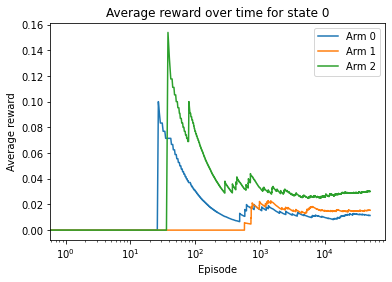

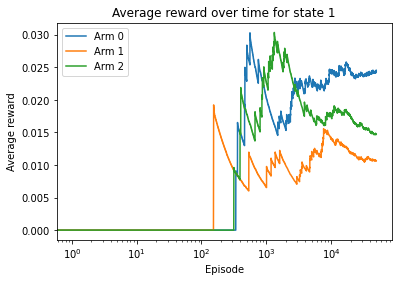

In [ ]:
bandit_payout_machines = [
    [0.01, 0.015, 0.03],
    [0.025, 0.01, 0.015]
]
bandit_reward_machines = [
    [1, 1, 1],
    [1, 1, 1]
]
n_machine = len(bandit_payout_machines)

bandit_env_machines = [BanditEnv(bandit_payout, bandit_reward)
                       for bandit_payout, bandit_reward in
                       zip(bandit_payout_machines, bandit_reward_machines)]

n_episode = 100000
n_action = len(bandit_payout_machines[0])
action_count = torch.zeros(n_machine, n_action)
action_total_reward = torch.zeros(n_machine, n_action)
action_avg_reward = [[[] for action in range(n_action)] for _ in range(n_machine)]

def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb).item()

Q_machines = torch.empty(n_machine, n_action)

for episode in range(n_episode):
    state = torch.randint(0, n_machine, (1,)).item()

    action = upper_confidence_bound(Q_machines[state], action_count[state], episode)
    reward = bandit_env_machines[state].step(action)[1]
    action_count[state][action] += 1
    action_total_reward[state][action] += reward
    Q_machines[state][action] = action_total_reward[state][action] / action_count[state][action]

    for a in range(n_action):
        if action_count[state][a]:
            action_avg_reward[state][a].append(action_total_reward[state][a] / action_count[state][a])
        else:
            action_avg_reward[state][a].append(0)

for state in range(n_machine):
    for action in range(n_action):
        plt.plot(action_avg_reward[state][action])
    plt.legend(['Arm {}'.format(action) for action in range(n_action)])
    plt.xscale('log')
    plt.title('Average reward over time for state {}'.format(state))
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.show()

Given the first state, ad 2 is the best ad, with the highest predicted CTR. Given the second state, ad 0 is the optimal ad, with the highest average reward. And these are both true.

Contextual bandits are a set of multi-armed bandits. Each bandit represents a unique state of the environment. The state provides a description of the environment, which helps the agent take more informed actions. In our advertising example, male users might be more likely to click an ad than female users. We simply used two slot machines to incorporate two states and searched for the best arm to pull given each state.

One thing to note is that contextual bandits are still different from MDPs, although they involve the concept of state. First, the states in contextual bandits are not determined by the previous actions or states, but are simply observations of the environment. Second, there is no delayed or discounted reward in contextual bandits because a bandit episode is one step. However, compared to multi-armed bandits, contextual bandits are closer to MDP as the actions are conditional to the states in the environment. It is safe to say that contextual bandits are in between multi-armed bandits and full MDP reinforcement learning.

## Custom Bandit Environments

In [ ]:
#export
class BanditTwoArmedDeterministicFixed(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[1, 0], r_dist=[1, 1])

In [ ]:
#export
class BanditTwoArmedHighLowFixed(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.2], r_dist=[1, 1])

In [ ]:
#export
class BanditTwoArmedHighHighFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.9], r_dist=[1, 1])

In [ ]:
#export
class BanditTwoArmedLowLowFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])

In [ ]:
#export
class BanditTenArmedRandomFixed(BanditEnv):
    """10 armed bandit with random probabilities assigned to payouts"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.full(bandits, 1)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [ ]:
#export
class BanditTenArmedUniformDistributedReward(BanditEnv):
    """10 armed bandit with that always pays out with a reward selected from a uniform distribution"""
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [ ]:
#export
class BanditTenArmedRandomRandom(BanditEnv):
    """10 armed bandit with random probabilities assigned to both payouts and rewards"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [ ]:
#export
class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

## Finding the best bandit arm

In [ ]:
#Let's just create a simple 2-armed bandit
env = BanditTwoArmedHighLowFixed()

# Since we created a 2-armed bandit, our action space will be 2 (as there are two arms), as shown here:
print(env.action_space.n)    # The preceding code will print: 2

# We can also check the probability distribution of the arm with:
print(env.p_dist) 

2
[0.8, 0.2]


### Find the best bandit arm with Epsilon-Greedy method

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, let's define the epsilon_greedy function.
def epsilon_greedy(epsilon):
    """First, we generate a random number from a uniform distribution. If the random 
    number is less than epsilon, then we pull the random arm; else, we pull 
    the best arm that has the maximum average reward"""

    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q)


# Now, let's play the game and try to find the best arm using the epsilon-greedy method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the epsilon-greedy method:
  arm = epsilon_greedy(epsilon=0.5)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  
# After all the rounds, we look at the average reward obtained from each of the arms:
print(Q)    # The preceding code will print something like this: [0.xx 0.yy]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

[0.84337349 0.17647059]
The optimal arm is arm 1


### Find the best bandit arm with Softmax method

We define the softmax function with the temperature T: 

$$\large P_i=\frac{e^{\frac{y_i}T}}{\sum_{k=1}^n e^{\frac{y_k}T}}$$

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, we define the softmax function with the temperature T:
def softmax(T):
  # Compute the probability of each arm based on the temperature equation:
  denom = sum([np.exp(i/T) for i in Q])
  probs = [np.exp(i/T)/denom for i in Q]
  # Select the arm based on the computed probability distribution of arms:
  arm = np.random.choice(env.action_space.n, p=probs)  
  return arm


# Now, let's play the game and try to find the best arm using the softmax exploration method.
# Let's begin by setting the temperature T to a high number, say, 50:
T = 50
# For each round:
for i in range(num_rounds):
  # Select the arm based on the softmax exploration method:
  arm = softmax(T)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  # Reduce the temperature T:
  T = T*0.99

# After all the rounds, we check the Q value, that is, the average reward of all the arms:
print(Q)    # The preceding code will print something like this: [0.xx 0.yy]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

[0.78431373 0.2244898 ]
The optimal arm is arm 1


### Find the best bandit arm with Upper Confidence Bound method
    
The algorithm of UCB is given as follows:
    
1. Select the arm whose upper confidence bound is high
2. Pull the arm and receive a reward
3. Update the arm's mean reward and confidence interval
4. Repeat *steps 1* to *3* for several rounds
    

Let N(a) be the number of times arm a was pulled and t be the total number of rounds, then the upper confidence bound of arm a can be computed as:

$$A_t \dot{=} \operatorname{argmax}_a \left[ Q_t(a) + c \sqrt{ \frac{\ln t}{N_t(a)} } \right]$$

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100

# Now, we define the UCB function, which returns the best arm as the 
# one that has the highest UCB:
def UCB(i):
  # Initialize the numpy array for storing the UCB of all the arms:
  ucb = np.zeros(2)
  # Before computing the UCB, we explore all the arms at least once, so for the 
  # first 2 rounds, we directly select the arm corresponding to the round number:
  if i < 2:
    return i
  # If the round is greater than 2, then we compute the UCB of all the arms as 
  # specified in the UCB equation and return the arm that has the highest UCB:
  else:
    for arm in range(2):
      ucb[arm] = Q[arm] + np.sqrt((2*np.log(sum(count))) / count[arm])
  return (np.argmax(ucb))

# Now, let's play the game and try to find the best arm using the UCB method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the UCB method:
  arm = UCB(i)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

The optimal arm is arm 1


### Find the best bandit arm with Thompson Sampling method
    
The steps involved in the Thomson sampling method are given here:

1. Initialize the beta distribution with alpha and beta set to equal values for all *k* arms
2. Sample a value from the beta distribution of all *k* arms
3. Pull the arm whose sampled value is high
4. If we win the game, then update the alpha value of the distribution to $\alpha = \alpha + 1$
5. If we lose the game, then update the beta value of the distribution to $\beta = \beta + 1$
6. Repeat steps 2 to *5* for many rounds

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Initialize the alpha value as 1 for both arms:
alpha = np.ones(2)

# Initialize the beta value as 1 for both arms:
beta = np.ones(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, let's define the thompson_sampling function
def thompson_sampling(alpha,beta):
  """we randomly sample values from the beta distributions of both arms and 
  return the arm that has the maximum sampled value"""
  samples = [np.random.beta(alpha[i]+1,beta[i]+1) for i in range(2)]
  return np.argmax(samples)


# Now, let's play the game and try to find the best arm using the Thompson sampling method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the Thompson sampling method:
  arm = thompson_sampling(alpha,beta)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm) 
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  # If we win the game, that is, if the reward is equal to 1, then we update 
  # the value of alpha to alpha+1, else we update the value of beta to beta+1:
  if reward==1:
    alpha[arm] = alpha[arm] + 1
  else:
    beta[arm] = beta[arm] + 1

# After all the rounds, we can select the optimal arm as the one that has the highest average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

The optimal arm is arm 1


In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-23 16:09:27

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

torch     : 1.10.0+cu111
numpy     : 1.19.5
gym       : 0.17.3
IPython   : 5.5.0
matplotlib: 3.2.2

